In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import joblib

In [42]:
def cargar_bd(
        path:str,
        sample:bool,
        columns:list,
        percent:float=0.1
        ):
    df = pd.read_csv(path, sep=',')
    if sample:
        df = df.sample(frac=percent, random_state=42)

    return df

In [43]:
columns = pd.read_csv('metadatos.csv', sep=',').columns.to_list()
data = cargar_bd(path='metadatos.csv', sample=False, columns=columns)

def tratamiento(data:pd.DataFrame):
    data = data.replace({'UNK': np.nan,
                         'True': True,
                         'False': False}).replace({True: 1, False: 0})
    data = data.dropna()
    return data

data = tratamiento(data)
data

C:\Users\Mosies Marquina\AppData\Local\Temp\ipykernel_17980\236354569.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'False': False}).replace({True: 1, False: 0})


,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
1,PAT_46,881,0.0,0.0,POMERANIA,POMERANIA,55,0.0,FEMALE,1.0,...,5.0,BCC,1.0,1.0,0.0,1.0,1.0,1.0,PAT_46_881_939.png,1
4,PAT_684,1302,0.0,1.0,POMERANIA,POMERANIA,79,0.0,MALE,1.0,...,5.0,BCC,1.0,1.0,0.0,0.0,1.0,1.0,PAT_684_1302_588.png,1
6,PAT_778,1471,0.0,1.0,GERMANY,ITALY,52,0.0,FEMALE,0.0,...,10.0,BCC,0.0,1.0,0.0,1.0,1.0,1.0,PAT_778_1471_835.png,1
7,PAT_117,179,0.0,0.0,POMERANIA,POMERANIA,74,1.0,FEMALE,0.0,...,10.0,BCC,1.0,1.0,1.0,0.0,1.0,1.0,PAT_117_179_983.png,1
9,PAT_705,4015,0.0,1.0,GERMANY,GERMANY,58,1.0,FEMALE,1.0,...,7.0,ACK,0.0,1.0,0.0,0.0,0.0,0.0,PAT_705_4015_413.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,PAT_492,937,0.0,1.0,POMERANIA,POMERANIA,70,0.0,MALE,0.0,...,13.0,SCC,0.0,1.0,0.0,0.0,0.0,1.0,PAT_492_937_43.png,1
2287,PAT_754,1429,0.0,0.0,ITALY,GERMANY,75,0.0,MALE,1.0,...,34.0,MEL,0.0,1.0,0.0,0.0,0.0,0.0,PAT_754_1429_380.png,1
2289,PAT_386,785,1.0,0.0,POMERANIA,POMERANIA,66,0.0,MALE,1.0,...,15.0,ACK,1.0,0.0,1.0,0.0,1.0,1.0,PAT_386_785_536.png,1
2294,PAT_46,880,0.0,0.0,POMERANIA,POMERANIA,55,0.0,FEMALE,1.0,...,12.0,BCC,1.0,1.0,0.0,1.0,0.0,0.0,PAT_46_880_140.png,1


In [5]:
def disgnostico(data:pd.DataFrame):
    data = data.replace({'UNK': np.nan,
                         'True': True,
                         'False': False}).replace({True: 1, False: 0})

    val = {}
    nul = {}
    for col in data.columns:
        unicos = data[col].unique().tolist()
        val[col] = unicos
        nulo = data[col].isnull().sum()
        nul[col] = round(float(nulo/data.shape[0]), 2)
   
    detalle = pd.DataFrame({
        'Columna': list(val.keys()),
        'Valor único': list(val.values()),	
        'Nulos': list(nul.values())
    })
    
    return detalle
    
disgnostico(data)


,Columna,Valor único,Nulos
0,patient_id,"[PAT_46, PAT_684, PAT_778, PAT_117, PAT_705, P...",0.0
1,lesion_id,"[881, 1302, 1471, 179, 4015, 1204, 54, 1540, 1...",0.0
2,smoke,"[0.0, 1.0]",0.0
3,drink,"[0.0, 1.0]",0.0
4,background_father,"[POMERANIA, GERMANY, BRAZIL, NETHERLANDS, ITAL...",0.0
5,background_mother,"[POMERANIA, ITALY, GERMANY, BRAZIL, POLAND, NO...",0.0
6,age,"[55, 79, 52, 74, 58, 78, 60, 64, 54, 82, 62, 6...",0.0
7,pesticide,"[0.0, 1.0]",0.0
8,gender,"[FEMALE, MALE]",0.0
9,skin_cancer_history,"[1.0, 0.0]",0.0


In [6]:
def estadistica_descriptiva(
        descrip,
        media:bool=0,
        desv_est:bool=0,
        miss:bool=0,
        val_max:bool=0,
        val_min:bool=0
        ):

    data = {}
    aux = descrip.dropna()
    if media:
        data['media'] = float(aux.mean().round(2))

    if desv_est:
        data['desv_est'] = float(aux.std().round(2))
    
    if miss:
        data['misssing'] = int(np.sum(descrip.isnull()))
    
    if val_max:
        data['val_max'] = float(aux.max().round(2))
    
    if val_min:
        data['val_min'] = float(aux.min().round(2))

    return data

info = {}
for col in data.columns:
    if data[col].dtype != 'object':
        des = estadistica_descriptiva(
            data[col],
            media=1,
            desv_est=1,
            miss=1,
            val_max=1,
            val_min=1
        )
        info[col] = des

info = pd.DataFrame(info)
info

,lesion_id,smoke,drink,age,pesticide,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,biopsed
media,1111.10,0.14,0.24,63.68,0.43,0.45,0.55,0.58,0.52,2.23,11.70,8.84,0.72,0.61,0.27,0.15,0.40,0.70,0.87
desv_est,834.83,0.35,0.43,14.15,0.50,0.50,0.50,0.49,0.50,0.73,7.12,5.28,0.45,0.49,0.45,0.35,0.49,0.46,0.34
misssing,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
val_max,4734.00,1.00,1.00,94.00,1.00,1.00,1.00,1.00,1.00,6.00,70.00,60.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
val_min,17.00,0.00,0.00,14.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [7]:
def imputar_datos(df:pd.DataFrame, lista_col:list, estrategia:list):
    copy = df.copy()
    for col, estrategia in zip(lista_col, estrategia):
        if estrategia == 'dropna':
            copy[col] = copy[col].fillna(copy[col].mode()[0])
        elif estrategia == 'mean':
            copy[col] = copy[col].fillna(copy[col].mean())
        elif estrategia == 'median':
            copy[col] = copy[col].fillna(copy[col].median())
        elif estrategia == 'zero':
            copy[col] = copy[col].fillna(0)

    return copy

cols = [col for col in data.columns.to_list() if data[col].isnull]
copy = imputar_datos(data, cols, 'median')

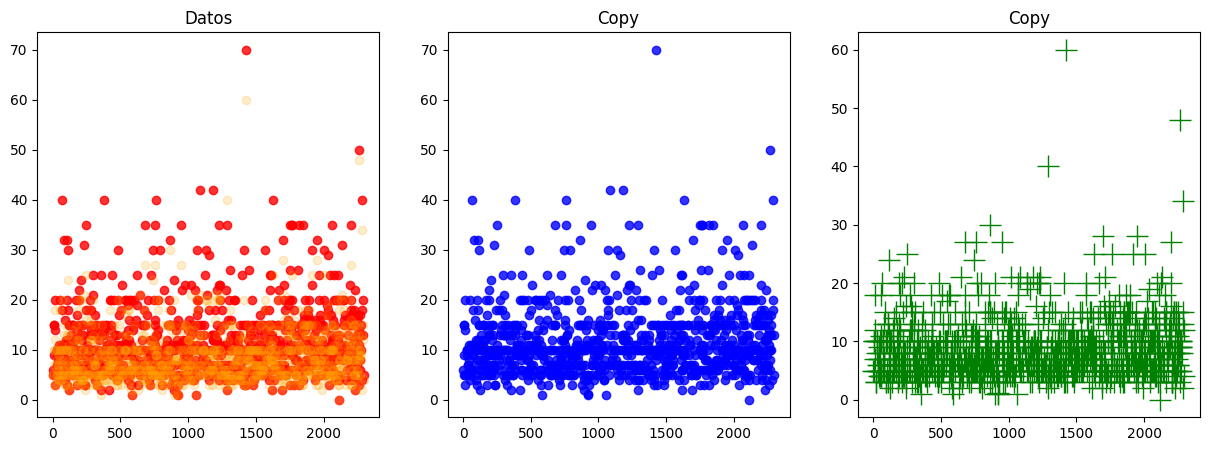

In [8]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title("Datos")
ax1.plot(data['diameter_1'], linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)
ax1.plot(data['diameter_2'], linewidth=0, marker="o", color="orange", alpha=0.2, markersize=6)

ax2.set_title("Copy")
ax2.plot(copy["diameter_1"], linewidth=0, marker="o", color="blue", alpha=0.8, markersize=6)

ax3.set_title("Copy")
ax3.plot(copy["diameter_2"], linewidth=0, marker="+", color="green", markersize=16)
plt.show()

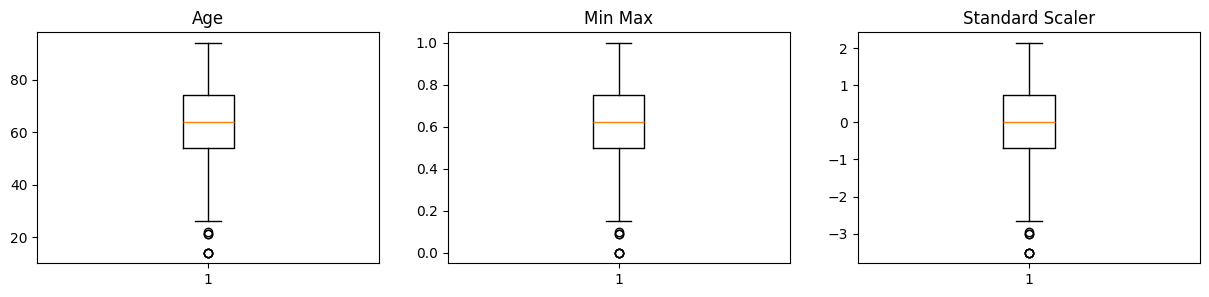

In [10]:
col_num = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_graficar = copy[col_num]
min_max = MinMaxScaler().fit_transform(df_graficar)
standard_scaler = StandardScaler().fit_transform(df_graficar)
df_min_max = pd.DataFrame(min_max, columns=[col_num])
df_standard_scaler = pd.DataFrame(standard_scaler, columns=[col_num])

def boxplot(
        descriptor,
        max_min,
        std_scaler
        ):
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax1.set_title(f"Age")
    ax1.boxplot(descriptor)
    ax2.set_title("Min Max")
    ax2.boxplot(max_min)
    ax3.set_title("Standard Scaler")
    ax3.boxplot(std_scaler)
    plt.show()
    
boxplot(df_graficar['age'], df_min_max['age'], df_standard_scaler['age'])

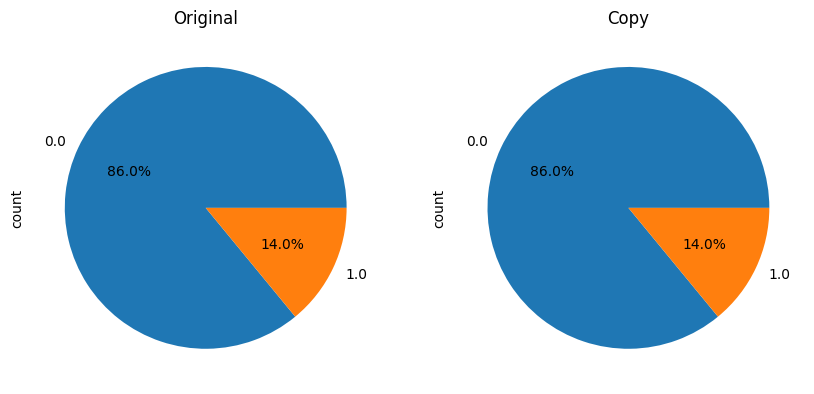

In [12]:
def cake(descriptor1, descriptor2):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.set_title("Original")
    descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
    ax2.set_title(f"Copy")
    descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
    plt.show()

cake(data['smoke'], copy['smoke'])

In [13]:
def normalizacion_datos(df:pd.DataFrame, tipo_normalizacion:str):
    columnas = df.columns.tolist()
    if tipo_normalizacion == 'MinMax':
        datos_normalizados = MinMaxScaler().fit_transform(df)
    elif tipo_normalizacion == 'StandardScaler':
        datos_normalizados = StandardScaler().fit_transform(df)
    
    df_result= pd.DataFrame(datos_normalizados, columns=[columnas])
    return df_result

df_datos_a_normalizar = df_graficar[['diameter_1', 'diameter_2', 'age', 'fitspatrick']]
df_MinMax = normalizacion_datos(df_datos_a_normalizar, 'MinMax')
df_StandardScaler = normalizacion_datos(df_datos_a_normalizar, 'StandardScaler')

In [24]:
def generar_train_test(df:pd.DataFrame, col_target:str, del_col:list, rand_st:int, test_tam:float):
    X = copy.drop(del_col, axis=1)
    y = copy[col_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
    return X_train, X_test, y_train, y_test

col_eliminar = [
    'diagnostic',
    'biopsed',
    'background_father',
    'background_mother',
    'gender',
    'patient_id',
    'region',
    'img_id'
    ]
random_state = 15
X_train, X_test, y_train, y_test = generar_train_test(copy, 'diagnostic', col_eliminar, random_state, 0.2)

In [15]:
class Procesamiento:
    def __init__(self, path:str, sample:bool, columnas:list, nombre_col_y:str, percent:float=0.5):
        self.path = path
        self.sample = self.sample
        self.columnas = columnas
        self.percent = percent
        self.nombre_col_y = nombre_col_y
        self.data = None
        self.copy = None

    def cargar_bd(self):
        df = pd.read_csv(self.path, sep=',')
        if self.sample:
            df = df.sample(frac=self.percent, random_state=42)
        self.data = df
        return data
    
    def tratamiento(self):
        if self.data is None:
            raise 'Empty data'
        
        data = self.data.replace({'UNK': np.nan,
                            'True': True,
                            'False': False}).replace({True: 1, False: 0})
        data = data.dropna()
        return data
    
    def disgnostico(self):
        if self.data is None:
            raise 'Empty data'
        
        data = self.data.replace({'UNK': np.nan,
                            'True': True,
                            'False': False}).replace({True: 1, False: 0})
        val = {}
        nul = {}
        for col in data.columns:
            unicos = data[col].unique().tolist()
            val[col] = unicos
            nulo = data[col].isnull().sum()
            nul[col] = round(float(nulo/data.shape[0]), 2)
    
        detalle = pd.DataFrame({
            'Columna': list(val.keys()),
            'Valor único': list(val.values()),	
            'Nulos': list(nul.values())
        })
        return detalle

    def imputar_datos(self, estrategia:list):
        copy = self.data.copy()
        for col, estrategia in zip(lista_col, estrategia):
            if estrategia == 'dropna':
                copy[col] = copy[col].fillna(copy[col].mode()[0])
            elif estrategia == 'mean':
                copy[col] = copy[col].fillna(copy[col].mean())
            elif estrategia == 'median':
                copy[col] = copy[col].fillna(copy[col].median())
            elif estrategia == 'zero':
                copy[col] = copy[col].fillna(0)
        self.copy = copy
        return copy
    
    def boxplot(self,
        descriptor,
        max_min,
        std_scaler
        ):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        ax1.set_title(f"Age")
        ax1.boxplot(descriptor)
        ax2.set_title("Min Max")
        ax2.boxplot(max_min)
        ax3.set_title("Standard Scaler")
        ax3.boxplot(std_scaler)

        return plt.show()
    
    def cake(self, descriptor1, descriptor2):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_title("Original")
        descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
        ax2.set_title(f"Copy")
        descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
        
        return plt.show()
    
    def normalizacion_datos(self, tipo:str):
        columnas = self.data.columns.tolist()
        if tipo == 'MinMax':
            datos_normalizados = MinMaxScaler().fit_transform(self.data)

        elif tipo == 'StandardScaler':
            datos_normalizados = StandardScaler().fit_transform(self.data)
        
        data = pd.DataFrame(datos_normalizados, columns=[columnas])
        return data
    
    def generar_train_test(self, col_target:str, del_col:list, rand_st:int, test_tam:float):
        X = self.copy.drop(del_col, axis=1)
        y = self.copy[col_target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
        return X_train, X_test, y_train, y_test
    

In [32]:
def clasificador(
        tipo,
        dir,
        X_t,
        y_t
        ):
    if tipo == 'naive_bayes':
        modelo = GaussianNB()
        
    elif tipo == 'logistic_regression':
        modelo = LogisticRegression()
        
    modelo.fit(X_t, y_t)
    ruta = dir + '/_' + tipo +'_model.pkl'
    joblib.dump(modelo, ruta)

    return ruta

In [33]:
ruta = clasificador('naive_bayes', 'models', X_train, y_train)
modelo = joblib.load(ruta)
modelo.theta_

array([[1.57085714e+03, 1.05820106e-01, 2.22222222e-01, 6.55873016e+01,
        4.86772487e-01, 3.96825397e-01, 5.23809524e-01, 6.08465608e-01,
        6.03174603e-01, 2.25396825e+00, 1.11058201e+01, 8.40211640e+00,
        7.77777778e-01, 2.43386243e-01, 1.21693122e-01, 5.29100529e-02,
        1.53439153e-01, 4.07407407e-01],
       [8.63545872e+02, 1.58256881e-01, 2.43119266e-01, 6.27591743e+01,
        4.58715596e-01, 4.77064220e-01, 5.34403670e-01, 5.43577982e-01,
        4.72477064e-01, 2.19724771e+00, 1.22756881e+01, 9.11513761e+00,
        7.82110092e-01, 7.45412844e-01, 4.15137615e-01, 1.37614679e-01,
        5.94036697e-01, 8.30275229e-01],
       [1.06280000e+03, 1.20000000e-01, 3.60000000e-01, 6.16400000e+01,
        5.20000000e-01, 4.80000000e-01, 6.40000000e-01, 4.40000000e-01,
        4.40000000e-01, 2.28000000e+00, 1.42000000e+01, 1.02400000e+01,
        2.00000000e-01, 8.80000000e-01, 0.00000000e+00, 8.00000000e-01,
        0.00000000e+00, 3.20000000e-01],
       [1.520

In [35]:
ruta = clasificador('logistic_regression', 'models', X_train, y_train)
modelo = joblib.load(ruta)
modelo.coef_

c:\Users\Mosies Marquina\VscProjects\UC\3.Ciencia de datos IA\Actividad3\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 5.34962446e-04, -2.59675584e-03, -3.96180499e-03,
         1.02710595e-02,  8.29236042e-04, -7.50063313e-03,
        -2.28249045e-03, -1.16782625e-03,  1.54114946e-03,
        -1.07210334e-02, -1.15915135e-02, -7.13281897e-03,
         6.14532430e-03, -2.68933746e-02, -9.22189779e-03,
        -8.63374583e-03, -1.58158433e-02, -2.30865414e-02],
       [-5.65298396e-04,  1.52018295e-03,  4.97401362e-03,
         2.63030214e-02,  1.07106237e-02,  1.07035741e-02,
         9.19222816e-04, -9.21804920e-04, -4.34201100e-03,
         2.07128862e-02,  4.16757359e-02,  2.01372349e-02,
         1.36628902e-02,  2.57687597e-02,  1.95102690e-02,
        -5.30659603e-04,  3.21873554e-02,  2.72240606e-02],
       [-4.51848074e-04, -3.03466615e-04,  7.92880403e-04,
        -1.07739173e-02, -2.63277144e-05, -3.24122359e-04,
         4.47539857e-04, -1.64931429e-03, -1.05789365e-03,
        -1.87448990e-03,  2.14694598e-02,  1.12692235e-02,
        -5.79234005e-03,  1.97833521e-03, -3.23286364e

In [ ]:
def evaluar_rendimiento(ruta, tipo, X_t, y_t):
    modelo = joblib.load(ruta)
    
    if tipo == 'matriz_confusion':
        y_p = modelo.predict(X_t)
        matriz_confusion = confusion_matrix(y_t, y_p)
        
        return matriz_confusion
    
    elif tipo == 'metricas_evaluacion':
        analisis = {}
        y_p = modelo.predict(X_t)
        accuracy = accuracy_score(y_t, y_p)
        analisis['accuracy'] = accuracy
        recall = recall_score(y_t, y_p, average='weighted')  
        analisis['recall'] = recall
        precision = precision_score(y_t, y_p, average='weighted', zero_division=0)
        analisis['precision'] = precision
        f1 = f1_score(y_t, y_p, average='weighted')
        analisis['f1_score'] = f1
        
        return analisis

In [39]:
ruta = clasificador('naive_bayes', 'models', X_train, y_train)
analisis = evaluar_rendimiento(ruta, 'metricas_evaluacion', X_test, y_test)
analisis

{'accuracy': 0.4393939393939394,
 'recall': np.float64(0.4393939393939394),
 'precision': np.float64(0.5944143827320763),
 'f1_score': np.float64(0.4748521677713332)}